# Анализ конверсии сайта электронной коммерции

Показателем конверсии называют отношение числа пользователей, совершивших некоторое целевое действие, к общему числу пользователей. Конверсия является важной метрикой в бизнесе, ее изменение, как правило, влияет на величину выручки. По этой причине компании стремятся увеличить конверсию за счет различных нововведений.

В данном проекте исследуется изменение конверсии сайта электронной коммерции за счет изменения интерфейса одной из его страниц. К контрольной группе относятся пользователи, которым показывается старая версия страницы, к тестовой - пользователи, которые видят новую версию.

## Импорт и предобработка данных

Импорт необходимых библиотек:

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import ttest_ind
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Считывание данных в *DataFrame*:

In [ ]:
conversion_data = pd.read_csv('ab_test.csv')
countries_data = pd.read_csv('countries_ab.csv')

Рассмотрим данные:

In [ ]:
conversion_data.head(5)

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


В первой таблице содержатся следующие данные:  
- *id* - идентификатор пользователя;  
- *time* - время посещения сайта;  
- *con_treat* - принадлежность к контрольной/тестовой группам;  
- *page* - страница, показываемая пользователю (старая/новая);  
- *converted* - совершение пользователем покупки (0 - не совершил, 1 - совершил).

In [ ]:
countries_data.head(5)

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Во второй таблице содержатся следующие данные:
- *id* - идентификатор пользователя;
- *country* - принадлежность стране.

Информация о данных:

In [ ]:
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
countries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


Пропущенных значений в таблице нет.

Очевидно, что пользователям, принадлежащим к тестовой группе, должна показываться новая страница, а пользователям, принадлежащим к контрольной, - старая. Проверим выполнение этого условия:

In [ ]:
correct_conversion_data = conversion_data[
    ((conversion_data['con_treat'] == 'control') &
    (conversion_data['page'] == 'old_page')) |
    (conversion_data['con_treat'] == 'treatment') &
    (conversion_data['page'] == 'new_page')
    ]
print('Число пользователей: {}'.format(conversion_data.shape[0]))
print('Число пользователей, правильно отнесенных к контрольной/тестовой группам: {}'.format(correct_conversion_data.shape[0]))

Число пользователей: 294478
Число пользователей, правильно отнесенных к контрольной/тестовой группам: 290585


Некоторые пользователи отнесены к неправильной группе. Удалим этих пользователей:

In [ ]:
conversion_data = conversion_data[
    ((conversion_data['con_treat'] == 'control') &
    (conversion_data['page'] == 'old_page')) |
    (conversion_data['con_treat'] == 'treatment') &
    (conversion_data['page'] == 'new_page')
    ]
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         290585 non-null  int64 
 1   time       290585 non-null  object
 2   con_treat  290585 non-null  object
 3   page       290585 non-null  object
 4   converted  290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


Найдем число уникальных пользователей:

In [ ]:
conversion_data.nunique()['id']

290584

In [ ]:
countries_data.nunique()['id']

290584

Число уникальных пользователей (290584) практически равно числу строк в первой таблице (290585), поэтому будем считать выборку независимой.

Объединим две таблицы и получим готовые для дальнейшего анализа данные:

In [ ]:
data = conversion_data.merge(countries_data, on='id')
data.head(5)

,id,time,con_treat,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


Выделим в отдельные таблицы данные пользователей контрольной и тестовой групп:

In [ ]:
control_data = data[data['con_treat'] == 'control']
control_data

,id,time,con_treat,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
4,864975,52:26.2,control,old_page,1,US
5,936923,20:49.1,control,old_page,0,US
7,719014,48:29.5,control,old_page,0,US
...,...,...,...,...,...,...
290578,718310,44:20.4,control,old_page,0,US
290580,751197,28:38.6,control,old_page,0,US
290581,945152,51:57.1,control,old_page,0,US
290582,734608,45:03.4,control,old_page,0,US


In [ ]:
treatment_data = data[data['con_treat'] == 'treatment']
treatment_data

,id,time,con_treat,page,converted,country
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
6,679687,26:46.9,treatment,new_page,1,CA
8,817355,58:09.0,treatment,new_page,1,UK
9,839785,11:06.6,treatment,new_page,1,CA
...,...,...,...,...,...,...
290569,677163,41:51.9,treatment,new_page,0,US
290572,925675,38:26.3,treatment,new_page,0,US
290575,643562,20:05.5,treatment,new_page,0,CA
290579,822004,36:46.1,treatment,new_page,0,CA


Полезно будет найти число пользователей каждой из стран в тестовой и контрольной группах:

In [ ]:
print('Число пользователей из США в контрольной группе равно {}'.format(
    len(control_data[control_data['country'] == 'US'])))
print('Число пользователей из США в тестовой группе равно {}'.format(
    len(treatment_data[treatment_data['country'] == 'US'])))
print('Число пользователей из Великобритании в контрольной группе равно {}'.format(
    len(control_data[control_data['country'] == 'UK'])))
print('Число пользователей из Великобритании в тестовой группе равно {}'.format(
    len(treatment_data[treatment_data['country'] == 'UK'])))
print('Число пользователей из Канады в контрольной группе равно {}'.format(
    len(control_data[control_data['country'] == 'CA'])))
print('Число пользователей из Канады в тестовой группе равно {}'.format(
    len(treatment_data[treatment_data['country'] == 'CA'])))

Число пользователей из США в контрольной группе равно 101716
Число пользователей из США в тестовой группе равно 101904
Число пользователей из Великобритании в контрольной группе равно 36360
Число пользователей из Великобритании в тестовой группе равно 36106
Число пользователей из Канады в контрольной группе равно 7198
Число пользователей из Канады в тестовой группе равно 7301


Важно отметить, что число пользователей в тестовой и контрольной группах как пользователей в целом, так и для каждой из стран, практически одинаково.

## Формулировка гипотез

В данной работе будем исследовать, как изменился показатель конверсии для всех пользователей в целом и для каждого региона по отдельности.  
Найдем показатель конверсии контрольной группы в целом и для каждого из регионов (США, Британии и Канады):

In [ ]:
print('Показатель конверсии контрольной группы для всех регионов равен {:.2f}%'.format(
    control_data['converted'].mean() * 100))
print('Показатель конверсии тестовой группы для всех регионов равен {:.2f}%'.format(
    treatment_data['converted'].mean() * 100))
print('Показатель конверсии контрольной группы для пользователей США равен {:.2f}%'.format(
    control_data[control_data['country'] == 'US']['converted'].mean() * 100))
print('Показатель конверсии тестовой группы для пользователей США равен {:.2f}%'.format(
    treatment_data[treatment_data['country'] == 'US']['converted'].mean() * 100))
print('Показатель конверсии контрольной группы для пользователей Великобритании равен {:.2f}%'.format(
    control_data[control_data['country'] == 'UK']['converted'].mean() * 100))
print('Показатель конверсии тестовой группы для пользователей Великобритании равен {:.2f}%'.format(
    treatment_data[treatment_data['country'] == 'UK']['converted'].mean() * 100))
print('Показатель конверсии контрольной группы для пользователей Канады равен {:.2f}%'.format(
    control_data[control_data['country'] == 'CA']['converted'].mean() * 100))
print('Показатель конверсии тестовой группы для пользователей Канады равен {:.2f}%'.format(
    treatment_data[treatment_data['country'] == 'CA']['converted'].mean() * 100))

Показатель конверсии контрольной группы для всех регионов равен 12.04%
Показатель конверсии тестовой группы для всех регионов равен 11.88%
Показатель конверсии контрольной группы для пользователей США равен 12.06%
Показатель конверсии тестовой группы для пользователей США равен 11.85%
Показатель конверсии контрольной группы для пользователей Великобритании равен 12.00%
Показатель конверсии тестовой группы для пользователей Великобритании равен 12.12%
Показатель конверсии контрольной группы для пользователей Канады равен 11.88%
Показатель конверсии тестовой группы для пользователей Канады равен 11.19%


Изобразим полученные показатели на графиках:

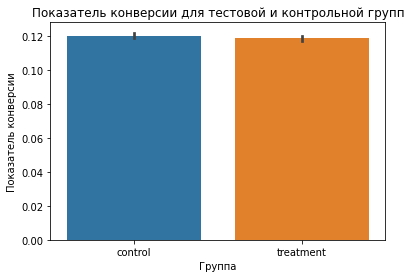

In [ ]:
sns.barplot(x='con_treat', y='converted', data=data)
plt.xlabel("Группа")
plt.ylabel("Показатель конверсии")
plt.title("Показатель конверсии для тестовой и контрольной групп");

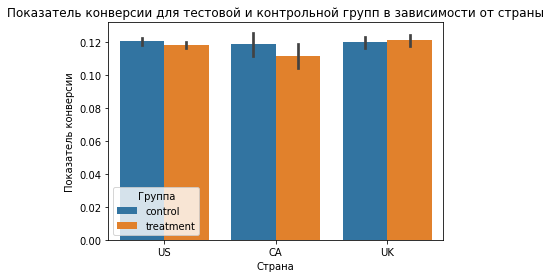

In [ ]:
sns.barplot(x='country', y='converted', hue='con_treat', data=data)
plt.xlabel("Страна")
plt.ylabel("Показатель конверсии")
plt.title("Показатель конверсии для тестовой и контрольной групп в зависимости от страны")
plt.legend(title="Группа")

Назначим размеры эффекта равными 10% от текущего показателя конверсии контрольных групп (12 * 0,1 = 1,2%). Тогда гипотезы можно сформулировать следующим образом:

1) Если изменить интерфейс страницы сайта, то можно добиться изменения показателя конверсии среди всех пользователей на 1,2%.  
2) Если изменить интерфейс страницы сайта, то можно добиться изменения показателя конверсии среди американских пользователей на 1,2%.  
3) Если изменить интерфейс страницы сайта, то можно добиться изменения показателя конверсии среди британских пользователей на 1,2%.  
4) Если изменить интерфейс страницы сайта, то можно добиться изменения показателя конверсии среди канадских пользователей на 1,2%.

## Выбор методов оценки стат. значимости

Выбор методов оценки стат. значимости будем проводить при помощи симуляций. В качестве возможных вариантов будем рассматривать *t*-тест и критерий согласия Пирсона $\chi$-квадрат.

In [ ]:
def t_test_power_simulation(
data_1,
data_2,
boot_it,
alpha):

    boot_len = max([len(data_1), len(data_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        s1 = data_1.sample(
            boot_len, 
            replace = True
        ).values
        
        s2 = data_2.sample(
            boot_len, 
            replace = True
        ).values
        
        p = ttest_ind(s1,s2,equal_var = False)   
        
        boot_data.append(p[1])

        pd_boot_data = pd.DataFrame(boot_data)

    a_f_5 = 0

    for u in boot_data:
        if u <= alpha:
            a_f_5+=1

    print("Мощность t-теста = {:.3f}% при alpha = {:.4f}.".format(a_f_5 / len(boot_data) * 100, alpha))
        

    fig = sns.histplot(pd_boot_data[0], bins = 80)
    plt.xlabel("p-значение")
    plt.ylabel("Частота")
    plt.title("Гистограмма p-значений для t-теста")


In [ ]:
def chi_square_power_simulation(
data_1,
data_2,
boot_it,
alpha):

    boot_len = max([len(data_1), len(data_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        s1 = data_1.sample(
            boot_len, 
            replace = True
        ).values
        
        s2 = data_2.sample(
            boot_len, 
            replace = True
        ).values
        
        f_obs = [len(s2) -s2.sum(), s2.sum()]
        f_exp = [len(s1) - s1.sum(), s1.sum()]
        f_exp = [el * len(s2) / len(s1) for el in f_exp]
        chi = chisquare(f_obs=f_obs, f_exp=f_exp)   
        
        boot_data.append(chi[1])

        pd_boot_data = pd.DataFrame(boot_data)

    a_f_5 = 0

    for u in boot_data:
        if u <= alpha:
            a_f_5+=1

    print("Мощность критерия хи-квадрат = {:.3f}% при alpha = {:.4f}.".format(a_f_5 / len(boot_data) * 100, alpha))
        

    fig = sns.histplot(pd_boot_data[0], bins = 80)
    plt.xlabel("p-значение")
    plt.ylabel("Частота")
    plt.title("Гистограмма p-значений для критерия хи-квадрат")


Проведем проверку корректности работы критериев на данных для всех пользователей, подавая на вход одинаковые данные. Расчет проводится для уровня значимости $\alpha$ = 0,05 / 4 (поправка Бонферонни для 4 гипотез).

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 1.340% при alpha = 0.0125.


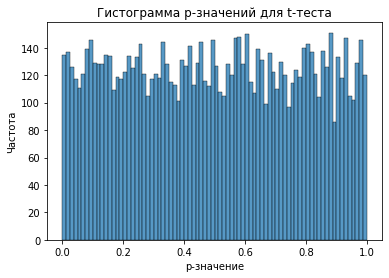

In [ ]:
t_test_power_simulation(data_1=control_data['converted'], data_2=control_data['converted'], boot_it=10000, alpha=0.05 / 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность критерия хи-квадрат = 7.440% при alpha = 0.0125.


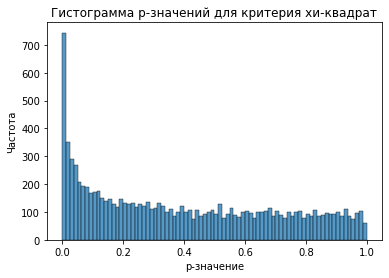

In [ ]:
chi_square_power_simulation(data_1=control_data['converted'], data_2=control_data['converted'], boot_it=10000, alpha=0.05 / 4)

Как видно из графиков, критерий $\chi$-квадрат работает некорректно, так как ошибка первого рода совершается с гораздо большей вероятностью, чем заданное альфа-значение, а сама гистограмма p-значений распределена неравномерно. *t*-критерий, напротив, показывает корректные результаты. Аналогичные тесты проведем для данных, сгруппированных по странам.

Для пользователей из США:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 1.330% при alpha = 0.0125.


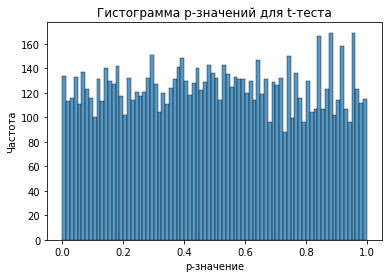

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'US']['converted'],
                        data_2=control_data[control_data['country'] == 'US']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность критерия хи-квадрат = 7.830% при alpha = 0.0125.


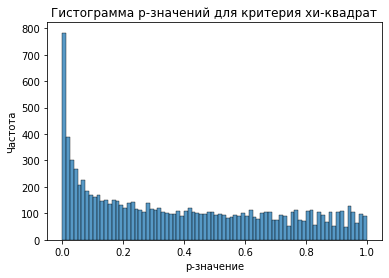

In [ ]:
chi_square_power_simulation(data_1=control_data[control_data['country'] == 'US']['converted'],
                        data_2=control_data[control_data['country'] == 'US']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

Для пользователей из Великобритании:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 1.450% при alpha = 0.0125.


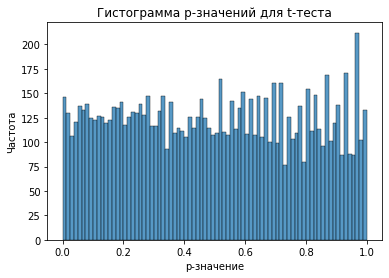

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'UK']['converted'],
                        data_2=control_data[control_data['country'] == 'UK']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность критерия хи-квадрат = 7.530% при alpha = 0.0125.


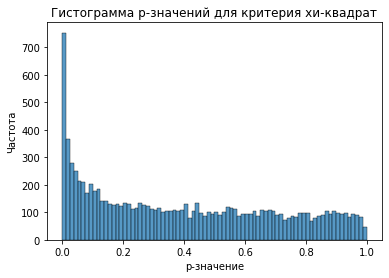

In [ ]:
chi_square_power_simulation(data_1=control_data[control_data['country'] == 'UK']['converted'],
                        data_2=control_data[control_data['country'] == 'UK']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

Для пользователей из Канады:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 1.210% при alpha = 0.0125.


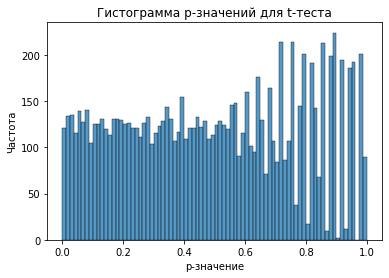

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'CA']['converted'],
                        data_2=control_data[control_data['country'] == 'CA']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность критерия хи-квадрат = 7.480% при alpha = 0.0125.


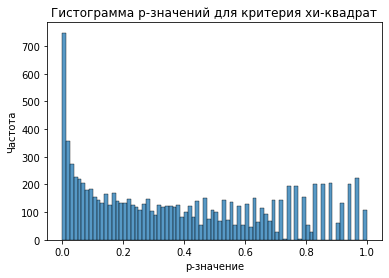

In [ ]:
chi_square_power_simulation(data_1=control_data[control_data['country'] == 'CA']['converted'],
                        data_2=control_data[control_data['country'] == 'CA']['converted'],
                        boot_it=10000,
                        alpha=0.05 / 4)

Аналогично, для данных, сгруппированных по странам, правильнее использовать *t*-критерий.

## Расчет мощности теста

Расчет мощности теста также будем проводить при помощи симуляций. Создадим искуственный массив из нулей и единиц со средним значением на 0,012 (1,2%) выше, чем показатель конверсии у контрольной группы:

In [ ]:
def data_with_uplift(data):
    new_data = np.zeros(1000)
    new_data[0:round(data.mean() * 1000) + 12] = 1
    new_data = pd.Series(new_data)
    return new_data

Проведем расчет мощности t-теста на данных для всех пользователей, сравнивая полученный массив и данными контрольной группы:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 100.000% при alpha = 0.0125.


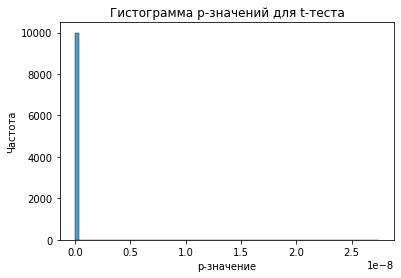

In [ ]:
t_test_power_simulation(data_1=control_data['converted'],
                        data_2=data_with_uplift(control_data['converted']),
                        boot_it=10000,
                        alpha=0.05 / 4)

Для пользователей из США:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 100.000% при alpha = 0.0125.


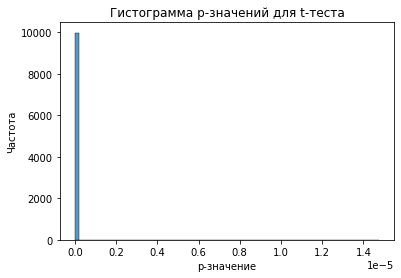

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'US']['converted'],
                        data_2=data_with_uplift(control_data[control_data['country'] == 'US']['converted']),
                        boot_it=10000,
                        alpha=0.05 / 4)

Для пользователей из Великобритании:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 99.200% при alpha = 0.0125.


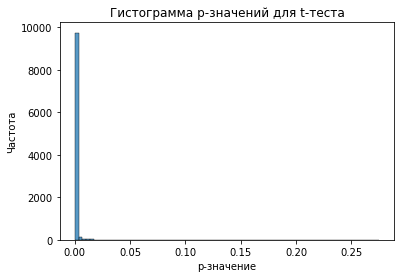

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'UK']['converted'],
                        data_2=data_with_uplift(control_data[control_data['country'] == 'UK']['converted']),
                        boot_it=10000,
                        alpha=0.05 / 4)

Для пользователей из Канады:

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста = 39.580% при alpha = 0.0125.


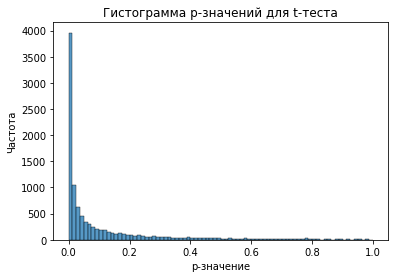

In [ ]:
t_test_power_simulation(data_1=control_data[control_data['country'] == 'CA']['converted'],
                        data_2=data_with_uplift(control_data[control_data['country'] == 'CA']['converted']),
                        boot_it=10000,
                        alpha=0.05 / 4)

Как видно из расчетов, мощность t-теста в первых трех случаях достигает практически 100%, что говорит о достаточном размере выборки для проведения теста при заданном размере эффекта. Для пользователей из Канады, напротив, мощность не достигает порогового значения 80%. Рассчитаем необходимый размер выборки для t-теста, при котором достигается достаточная мощность, предварительно найдя размер эффекта:

In [ ]:
std_A = control_data[control_data['country'] == 'CA']['converted'].std(ddof=1)
std_B = data_with_uplift(control_data[control_data['country'] == 'CA']['converted']).std(ddof=1)
mean_A = control_data[control_data['country'] == 'CA']['converted'].mean()
mean_B = data_with_uplift(control_data[control_data['country'] == 'CA']['converted']).mean()
pooled_std = (std_A ** 2 / 2 + std_B ** 2 / 2)**0.5
effect_size = (mean_B - mean_A) / pooled_std

In [ ]:
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
nobs1=None, ratio=1.0, alpha=0.05 / 4, power=0.8)
print('Необходимый размер выборки: {:.0f}'.format(result))

Необходимый размер выборки: 16337


## Оценка стат. значимости

Теперь можно использовать *t*-критерий для оценки стат. значимости различий в тестовой и контрольной группах. Проверим гипотезу о равенстве показателей конверсии в тестовой и контрольной группах вне зависимости от страны пользователя:

In [ ]:
st = p = ttest_ind(control_data['converted'], treatment_data['converted'], equal_var = False) 
alpha = 0.05 / 4
print('p-значение по критерию Стьюдента = {}'.format(st[1]))
print('alpha = {}, различия статистически {}значимы'.format(alpha, {True: '', False: 'не'} [st[1] < alpha]))

p-значение по критерию Стьюдента = 0.18965416073470676
alpha = 0.0125, различия статистически незначимы


Таким образом, нет оснований отвергать гипотезу о равенстве показателей конверсий в тестовой и контрольной группах.  
Проверим гипотезу о равенстве показателей конверсии в тестовой и контрольной группах для пользователей из США:

In [ ]:
st = ttest_ind(control_data[control_data['country'] == 'US']['converted'],
                   treatment_data[treatment_data['country'] == 'US']['converted'],
                   equal_var = False) 
alpha = 0.05 / 4
print('p-значение по критерию Стьюдента = {}'.format(st[1]))
print('alpha = {}, различия статистически {}значимы'.format(alpha, {True: '', False: 'не'} [st[1] < alpha]))

p-значение по критерию Стьюдента = 0.13206900494943818
alpha = 0.0125, различия статистически незначимы


Таким образом, нет оснований отвергать гипотезу о равенстве показателей конверсий в тестовой и контрольной группах для пользователей из США.  
Проверим гипотезу о равенстве показателей конверсии в тестовой и контрольной группах для пользователей из Великобритании:

In [ ]:
st = ttest_ind(control_data[control_data['country'] == 'UK']['converted'],
                   treatment_data[treatment_data['country'] == 'UK']['converted'],
                   equal_var = False) 
alpha = 0.05 / 4
print('p-значение по критерию Стьюдента = {}'.format(st[1]))
print('alpha = {}, различия статистически {}значимы'.format(alpha, {True: '', False: 'не'} [st[1] < alpha]))

p-значение по критерию Стьюдента = 0.6348750392294689
alpha = 0.0125, различия статистически незначимы


Таким образом, нет оснований отвергать гипотезу о равенстве показателей конверсий в тестовой и контрольной группах для пользователей из Великобритании.  
Найдем текущее p-value *t*-теста для пользователей из Канады:

In [ ]:
st = ttest_ind(control_data[control_data['country'] == 'CA']['converted'],
                   treatment_data[treatment_data['country'] == 'CA']['converted'],
                   equal_var = False) 
print('p-значение по критерию Стьюдента = {}'.format(st[1]))

p-значение по критерию Стьюдента = 0.1947734557196999


Текущее p-значение превышает $\alpha$, но, несмотря на это, нельзя принимать нулевую гипотезу, так как, как было показано ранее, размера выборки недостаточно для надежных выводов.

## Выводы

В ходе исследования удалось проверить три гипотезы из поставленных четырех. При рассмотрении всех пользователей в целом, а также  пользователей из США и Великобритании в отдельности, новая версия страницы не оказывает статистически значимого влияния на показатель конверсии сайта электронной коммерции. Для проверки четвертой гипотезы об изменении конверсии у канадских пользователей необходимо продолжать эксперимент.